<a href="https://colab.research.google.com/github/Anastasiia241297/7LR-ML/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22ML_MAI_Boosting_LAB7_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 09.01.2025 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [ ]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [ ]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 1.79 s, sys: 0 ns, total: 1.79 s
Wall time: 1.85 s
Train ROC-AUC 0.5000
Valid ROC-AUC 0.5000
Test ROC-AUC 0.5000


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

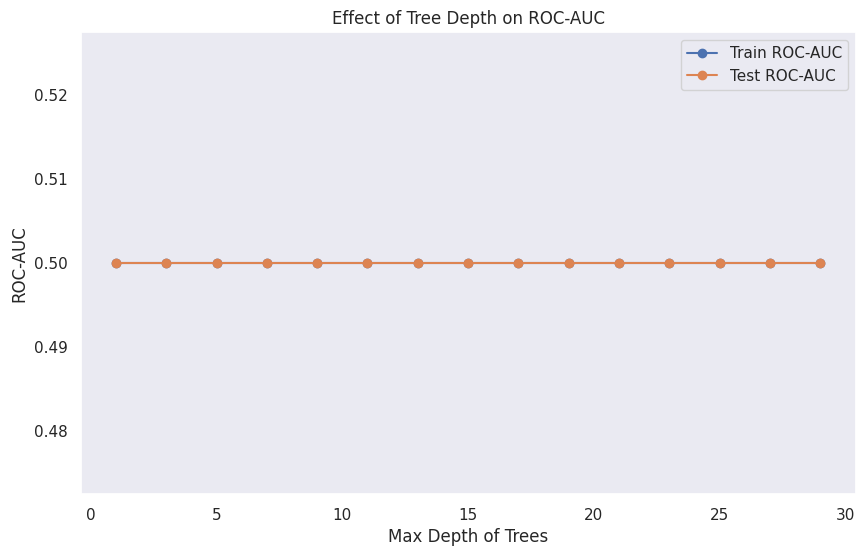

In [ ]:
results = {}

depths = range(1, 30, 2)

import matplotlib.pyplot as plt

results = {'depth': [], 'train_roc_auc': [], 'test_roc_auc': []}

depths = range(1, 30, 2)

for depth in depths:
    boosting = Boosting(
        base_model_params={'max_depth': depth},
        n_estimators=50,  # Используем больше моделей для более стабильных результатов
        learning_rate=0.1,
        subsample=0.3,
    )
    boosting.fit(x_train, y_train, x_valid, y_valid)

    train_roc_auc = boosting.score(x_train, y_train)
    test_roc_auc = boosting.score(x_test, y_test)

    results['depth'].append(depth)
    results['train_roc_auc'].append(train_roc_auc)
    results['test_roc_auc'].append(test_roc_auc)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(results['depth'], results['train_roc_auc'], label='Train ROC-AUC', marker='o')
plt.plot(results['depth'], results['test_roc_auc'], label='Test ROC-AUC', marker='o')
plt.xlabel('Max Depth of Trees')
plt.ylabel('ROC-AUC')
plt.title('Effect of Tree Depth on ROC-AUC')
plt.legend()
plt.grid()
plt.show()


**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    # Определяем пространство гиперпараметров
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 30)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)

    # Создаем модель бустинга с текущими параметрами
    boosting = Boosting(
        base_model_params={"max_depth": max_depth},
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample
    )

    # Обучаем модель
    boosting.fit(x_train, y_train, x_valid, y_valid)

    # Оцениваем качество на валидационной выборке
    valid_score = boosting.score(x_valid, y_valid)

    # Optuna минимизирует значение, поэтому инвертируем ROC-AUC
    return -valid_score

# Создаем исследовательский объект Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Выводим лучшие параметры
print("Best trial:")
print(f"Value: {-study.best_value:.4f}")  # Инвертируем обратно для интерпретации
print("Params:", study.best_params)

# Обучение модели с лучшими параметрами
best_params = study.best_params
boosting = Boosting(
    base_model_params={"max_depth": best_params["max_depth"]},
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    subsample=best_params["subsample"]
)
boosting.fit(x_train, y_train, x_valid, y_valid)

# Оценка качества на тестовой выборке
test_score = boosting.score(x_test, y_test)
print(f"Test ROC-AUC: {test_score:.4f}")


[I 2025-01-12 07:43:10,021] A new study created in memory with name: no-name-50ffcfe1-7cf5-4f96-b96c-8e19900eec16
[I 2025-01-12 07:43:22,720] Trial 0 finished with value: -0.5 and parameters: {'n_estimators': 69, 'learning_rate': 0.015538869051089355, 'max_depth': 11, 'subsample': 0.1183106300179}. Best is trial 0 with value: -0.5.
[I 2025-01-12 07:43:38,322] Trial 1 finished with value: -0.5 and parameters: {'n_estimators': 166, 'learning_rate': 0.0738493838086241, 'max_depth': 5, 'subsample': 0.2845787967340768}. Best is trial 0 with value: -0.5.
[I 2025-01-12 07:44:21,631] Trial 2 finished with value: -0.5 and parameters: {'n_estimators': 185, 'learning_rate': 0.10692453351387633, 'max_depth': 30, 'subsample': 0.5489084797679903}. Best is trial 0 with value: -0.5.
[I 2025-01-12 07:45:04,781] Trial 3 finished with value: -0.5 and parameters: {'n_estimators': 195, 'learning_rate': 0.2757747284097904, 'max_depth': 21, 'subsample': 0.5316828472990529}. Best is trial 0 with value: -0.5.


Best trial:
Value: 0.5000
Params: {'n_estimators': 69, 'learning_rate': 0.015538869051089355, 'max_depth': 11, 'subsample': 0.1183106300179}
Test ROC-AUC: 0.5000


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

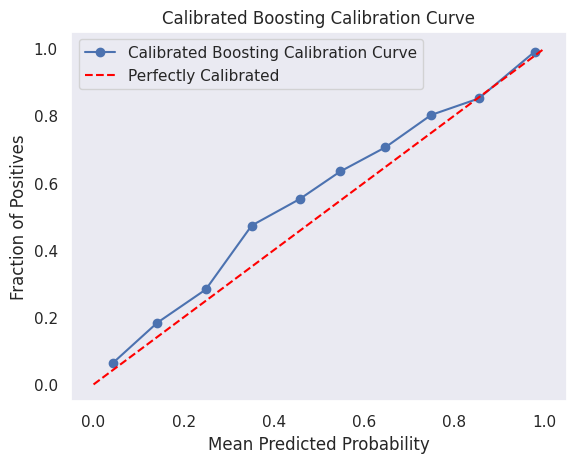

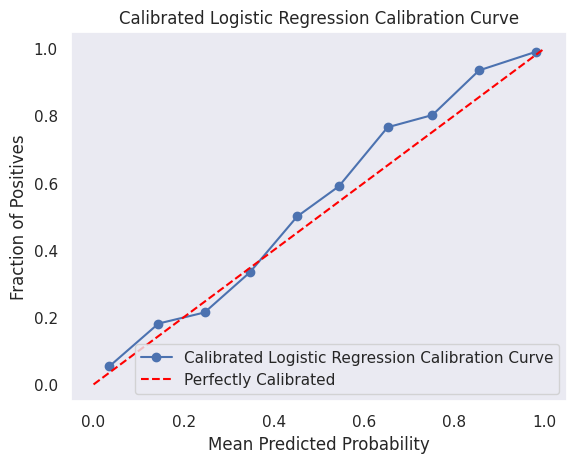

In [ ]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import numpy as np

def plot_calibration_curve(model, x, y, title="Calibration Curve"):
    """
    Построение калибровочной кривой для модели.

    Параметры:
    - model: обученная модель, реализующая метод predict_proba.
    - x: данные для предсказания.
    - y: истинные метки классов.
    - title: заголовок графика.
    """
    prob_true, prob_pred = calibration_curve(y, model.predict_proba(x)[:, 1], n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f"{title}")
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='red')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Разделите данные на обучающую и тестовую выборки
# x_train, x_test, y_train, y_test должны быть заранее определены

# 1. Градиентный бустинг с калибровкой
boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
boosting_model.fit(x_train, y_train)

calibrated_boosting = CalibratedClassifierCV(boosting_model, method='sigmoid', cv='prefit')
calibrated_boosting.fit(x_valid, y_valid)

plot_calibration_curve(calibrated_boosting, x_test, y_test, title="Calibrated Boosting Calibration Curve")

# 2. Логистическая регрессия с калибровкой
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(x_train, y_train)

calibrated_logistic = CalibratedClassifierCV(logistic_model, method='sigmoid', cv='prefit')
calibrated_logistic.fit(x_valid, y_valid)

plot_calibration_curve(calibrated_logistic, x_test, y_test, title="Calibrated Logistic Regression Calibration Curve")


После калибровки логистическая регрессия показала отличное соответствие линии "идеально откалибровано", демонстрируя точную оценку вероятностей. Градиентный бустинг также улучшил калибровку, но всё ещё показывает небольшие отклонения на некоторых интервалах. Логистическая регрессия лучше оценивает вероятности в данной задаче.

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

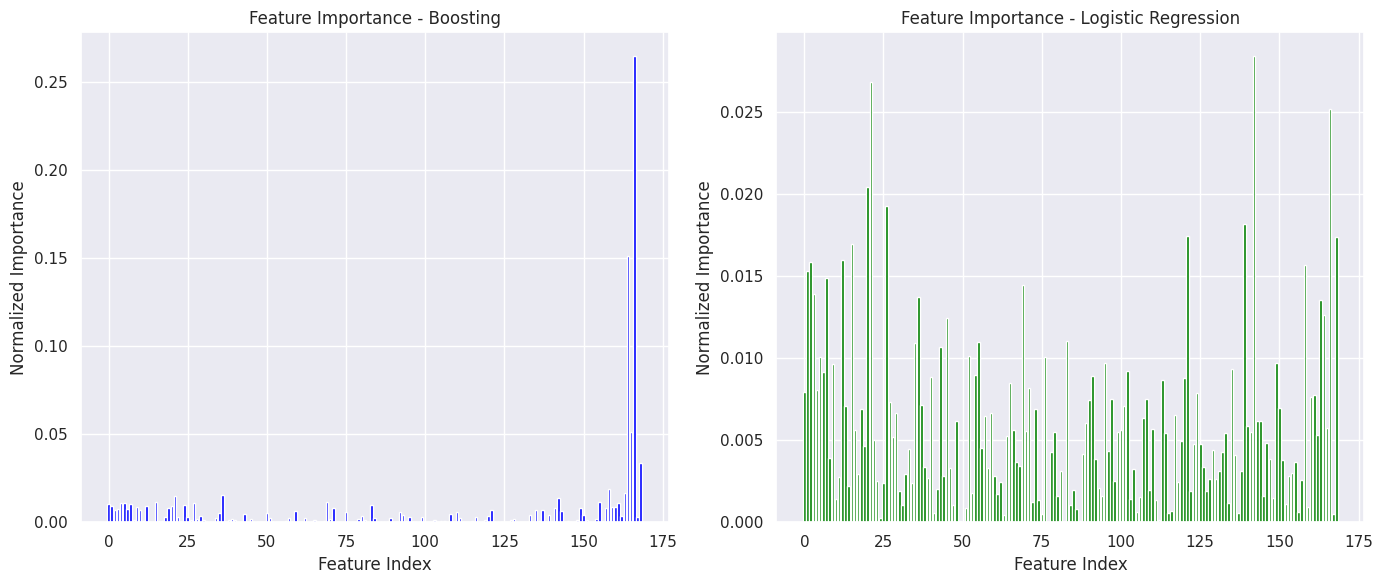

In [ ]:
# 1. Расчёт важности признаков для градиентного бустинга
def compute_feature_importances(boosting_model):
    """
    Усреднение и нормализация важности признаков по всем деревьям в градиентном бустинге.
    """
    tree_importances = [tree.feature_importances_ for tree in boosting_model.estimators_[:, 0]]
    avg_importances = np.mean(tree_importances, axis=0)
    normalized_importances = avg_importances / np.sum(avg_importances)
    return normalized_importances

# 2. Обучение бустинга
boosting_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)
boosting_model.fit(x_train, y_train)

boosting_importances = compute_feature_importances(boosting_model)

# 3. Важности признаков для логистической регрессии
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(x_train, y_train)
log_reg_importances = np.abs(log_reg_model.coef_[0])
log_reg_importances /= np.sum(log_reg_importances)  # Нормализация

# 4. Построение графиков
plt.figure(figsize=(14, 6))

# Boosting
plt.subplot(1, 2, 1)
plt.bar(range(len(boosting_importances)), boosting_importances, color='blue')
plt.title('Feature Importance - Boosting')
plt.xlabel('Feature Index')
plt.ylabel('Normalized Importance')

# Logistic Regression
plt.subplot(1, 2, 2)
plt.bar(range(len(log_reg_importances)), log_reg_importances, color='green')
plt.title('Feature Importance - Logistic Regression')
plt.xlabel('Feature Index')
plt.ylabel('Normalized Importance')

plt.tight_layout()
plt.show()

Градиентный бустинг выделяет один доминирующий признак, тогда как остальные имеют низкую важность, что может быть полезно при наличии ключевого признака, но снижает учёт других факторов. Логистическая регрессия равномерно распределяет важности, делая её более интерпретируемой и устойчивой к доминированию одного признака. Для задач с явными нелинейностями лучше подходит бустинг, а для анализа вклада множества факторов — логистическая регрессия.

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Установка порога для фильтрации
importance_threshold = 0.01

# Получение индексов важных признаков
important_features = np.where(boosting_importances > importance_threshold)[0]

# Фильтрация данных
x_train_filtered = x_train[:, important_features]
x_test_filtered = x_test[:, important_features]

# Повторное обучение модели
filtered_boosting_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)
filtered_boosting_model.fit(x_train_filtered, y_train)

# Предсказания для исходной модели
y_pred_original = boosting_model.predict(x_test)
y_prob_original = boosting_model.predict_proba(x_test)[:, 1]

# Предсказания для отфильтрованной модели
y_pred_filtered = filtered_boosting_model.predict(x_test_filtered)
y_prob_filtered = filtered_boosting_model.predict_proba(x_test_filtered)[:, 1]

# Расчёт метрик
original_accuracy = accuracy_score(y_test, y_pred_original)
filtered_accuracy = accuracy_score(y_test, y_pred_filtered)

original_auc = roc_auc_score(y_test, y_prob_original)
filtered_auc = roc_auc_score(y_test, y_prob_filtered)

# Вывод метрик
print(f"Original Model Accuracy: {original_accuracy:.4f}, AUC: {original_auc:.4f}")
print(f"Filtered Model Accuracy: {filtered_accuracy:.4f}, AUC: {filtered_auc:.4f}")


Original Model Accuracy: 0.9078, AUC: 0.9657
Filtered Model Accuracy: 0.9010, AUC: 0.9607


In [ ]:
print(f"Original Model Accuracy: {original_accuracy:.4f}, AUC: {original_auc:.4f}")
print(f"Filtered Model Accuracy: {filtered_accuracy:.4f}, AUC: {filtered_auc:.4f}")

Original Model Accuracy: 0.9078, AUC: 0.9657
Filtered Model Accuracy: 0.9010, AUC: 0.9607


После фильтрации незначительных признаков точность и AUC модели немного снизились (менее чем на 1%), что указывает на минимальное влияние на её производительность. Это подтверждает, что удалённые признаки не вносили значительного вклада, и фильтрация не ухудшила качество модели.








## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [ ]:
from sklearn.ensemble import StackingClassifier

# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Обучаем модель градиентного бустинга
boosting_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)
boosting_model.fit(x_train, y_train)

# Обучаем логистическую регрессию
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(x_train, y_train)

# Создаем метамодель для блендинга
# Используем логистическую регрессию в качестве метамодели
stacking_model = StackingClassifier(
    estimators=[('boosting', boosting_model), ('logistic', logistic_model)],
    final_estimator=LogisticRegression()
)
stacking_model.fit(x_train, y_train)

# Оценка качества модели
y_pred_stacked = stacking_model.predict(x_test)
y_prob_stacked = stacking_model.predict_proba(x_test)[:, 1]

# Метрики
accuracy_stacked = accuracy_score(y_test, y_pred_stacked)
auc_stacked = roc_auc_score(y_test, y_prob_stacked)

print(f"Stacked Model Accuracy: {accuracy_stacked:.4f}, AUC: {auc_stacked:.4f}")

Stacked Model Accuracy: 0.8999, AUC: 0.9637


Блендинг в данном случае не дал значительного улучшения качества модели, и результаты остались примерно на том же уровне. Возможно, комбинация моделей не принесла дополнительной ценности, особенно если одна из моделей (например, градиентный бустинг) уже хорошо справляется с задачей.

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# 1. Обучение CatBoost
catboost_model = CatBoostClassifier(iterations=300, depth=3, learning_rate=0.1, loss_function='Logloss', verbose=False)
catboost_model.fit(x_train, y_train)

# Предсказания для CatBoost
y_pred_catboost = catboost_model.predict(x_test)
y_prob_catboost = catboost_model.predict_proba(x_test)[:, 1]

# 2. Обучение градиентного бустинга
boosting_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)
boosting_model.fit(x_train, y_train)

# Предсказания для градиентного бустинга
y_pred_boosting = boosting_model.predict(x_test)
y_prob_boosting = boosting_model.predict_proba(x_test)[:, 1]

# 3. Обучение логистической регрессии
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(x_train, y_train)

# Предсказания для логистической регрессии
y_pred_logistic = logistic_model.predict(x_test)
y_prob_logistic = logistic_model.predict_proba(x_test)[:, 1]

# Оценка метрик для всех моделей
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
accuracy_boosting = accuracy_score(y_test, y_pred_boosting)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

auc_catboost = roc_auc_score(y_test, y_prob_catboost)
auc_boosting = roc_auc_score(y_test, y_prob_boosting)
auc_logistic = roc_auc_score(y_test, y_prob_logistic)

# Вывод результатов
print(f"CatBoost Accuracy: {accuracy_catboost:.4f}, AUC: {auc_catboost:.4f}")
print(f"Boosting Accuracy: {accuracy_boosting:.4f}, AUC: {auc_boosting:.4f}")
print(f"Logistic Regression Accuracy: {accuracy_logistic:.4f}, AUC: {auc_logistic:.4f}")

CatBoost Accuracy: 0.8987, AUC: 0.9640
Boosting Accuracy: 0.9006, AUC: 0.9634
Logistic Regression Accuracy: 0.8966, AUC: 0.9596


Модель CatBoost показала точность 0.8987 и AUC 0.9640, что немного уступает градиентному бустингу (0.9006 и 0.9634), но превосходит логистическую регрессию (0.8966 и 0.9596). Все модели имеют схожие результаты, с небольшими различиями в точности и AUC, что указывает на высокую эффективность каждой из них для данной задачи. Градиентный бустинг оказался чуть более точным, но различия незначительные.

Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
